In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(MouseThymusAgeing)
library(scuttle)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
thy.sce <- MouseSMARTseqData() # this function downloads the full SCE object


snapshotDate(): 2021-10-19

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?MouseThymusAgeing and browseVignettes('MouseThymusAgeing') fo

In [3]:
thy.sce <- logNormCounts(thy.sce)
thy.sce

class: SingleCellExperiment 
dim: 48801 2327 
metadata(0):
assays(2): counts logcounts
rownames(48801): ERCC-00002 ERCC-00003 ... ENSMUSG00000064371
  ENSMUSG00000064372
rowData names(6): Geneid Chr ... Strand Length
colnames(2327): B13.B002229.1_52.1.32.1_S109
  B13.B002297.1_32.4.52.1_S73 ... P9.B002345.5_52.1.32.1_S93
  P9.B002450.5_4.52.16.1_S261
colData names(11): CellID ClusterID ... SubType sizeFactor
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(0):

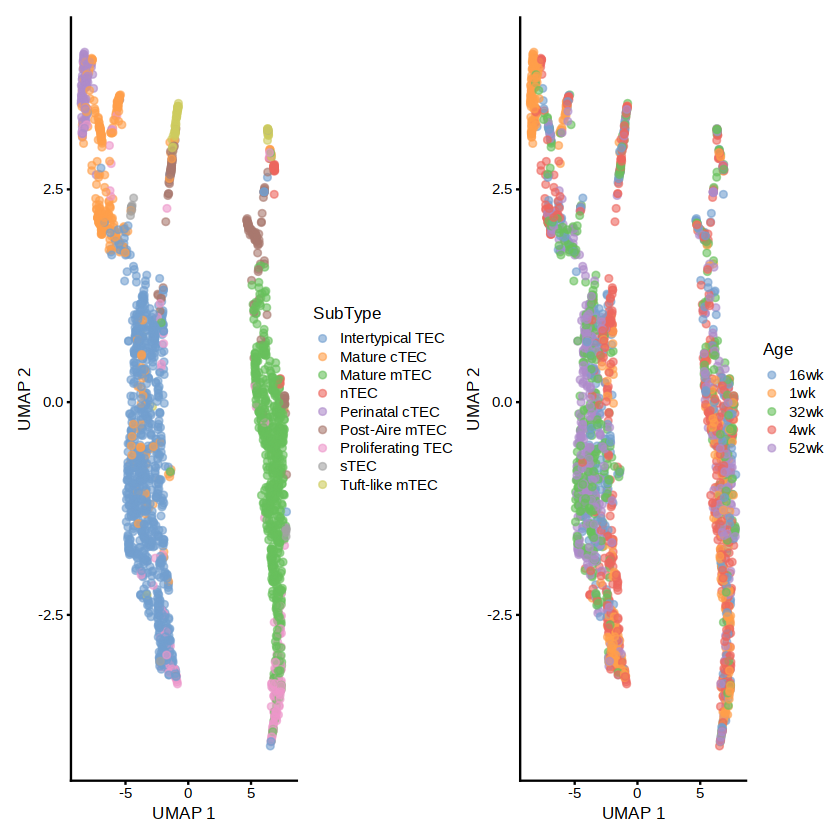

In [4]:
thy.sce <- runUMAP(thy.sce) # add a UMAP for plotting results later

thy.milo <- Milo(thy.sce) # from the SCE object
reducedDim(thy.milo, "UMAP") <- reducedDim(thy.sce, "UMAP")

plotUMAP(thy.milo, colour_by="SubType") + plotUMAP(thy.milo, colour_by="Age")

In [5]:
# we build KNN graph
thy.milo <- buildGraph(thy.milo, k = 10, d = 30)


Constructing kNN graph with k:10



In [6]:
thy.milo <- makeNhoods(thy.milo, prop = 0.1, k = 10, d=30, refined = TRUE, refinement_scheme="graph") # make nhoods using graph-only as this is faster

Checking valid object

Running refined sampling with graph



In [7]:
colData(thy.milo)$Sample <- paste(colData(thy.milo)$SortDay, colData(thy.milo)$Age, sep="_")
thy.milo <- countCells(thy.milo, meta.data = data.frame(colData(thy.milo)), samples="Sample") # make the nhood X sample counts matrix

Checking meta.data validity

Counting cells in neighbourhoods



In [79]:
thy.design <- data.frame(colData(thy.milo))[,c("Sample", "SortDay", "Age")]
thy.design <- distinct(thy.design)
rownames(thy.design) <- thy.design$Sample
## Reorder rownames to match columns of nhoodCounts(milo)
thy.design <- thy.design[colnames(nhoodCounts(thy.milo)), , drop=FALSE]
table(thy.design$Age)



16wk  1wk 32wk  4wk 52wk 
   5    5    5    5    5 

In [80]:
rownames(thy.design) <- thy.design$Sample
contrast.1 <- c("Age1wk - Age4wk") # the syntax is <VariableName><ConditionLevel> - <VariableName><ControlLevel>

# we need to use the ~ 0 + Variable expression here so that we have all of the levels of our variable as separate columns in our model matrix
da_results <- testNhoods(thy.milo, design = ~ 0 + Age, design.df = thy.design, model.contrasts = contrast.1, fdr.weighting="graph-overlap")

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting



In [81]:
table(da_results$SpatialFDR < 0.1)


FALSE  TRUE 
  185    20 

In [82]:
contrast.all <- c("Age1wk - Age4wk", "Age4wk - Age16wk", "Age16wk - Age32wk", "Age32wk - Age52wk")

# this is the edgeR code called by `testNhoods`
model <- model.matrix(~ 0 + Age, data=thy.design)
mod.constrast <- makeContrasts(contrasts=contrast.all, levels=model)

mod.constrast

,Age1wk - Age4wk,Age4wk - Age16wk,Age16wk - Age32wk,Age32wk - Age52wk
Age16wk,0,-1,1,0
Age1wk,1,0,0,0
Age32wk,0,0,-1,1
Age4wk,-1,1,0,0
Age52wk,0,0,0,-1


In [93]:
model <- model.matrix(~ 0 + Age, data=thy.design)
ave.contrast <- c("Age1wk - Age4wk")
mod.constrast <- makeContrasts(contrasts=ave.contrast, levels=model)

mod.constrast

,Age1wk - Age4wk
Age1wk,1
Age16wk,0
Age32wk,0
Age4wk,-1
Age52wk,0


In [94]:
da_results <- testNhoods(thy.milo, design = ~ 0 + Age, design.df = thy.design, model.contrasts = ave.contrast, fdr.weighting="graph-overlap")

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting



In [95]:
table(da_results$SpatialFDR < 0.1)


FALSE  TRUE 
  185    20 

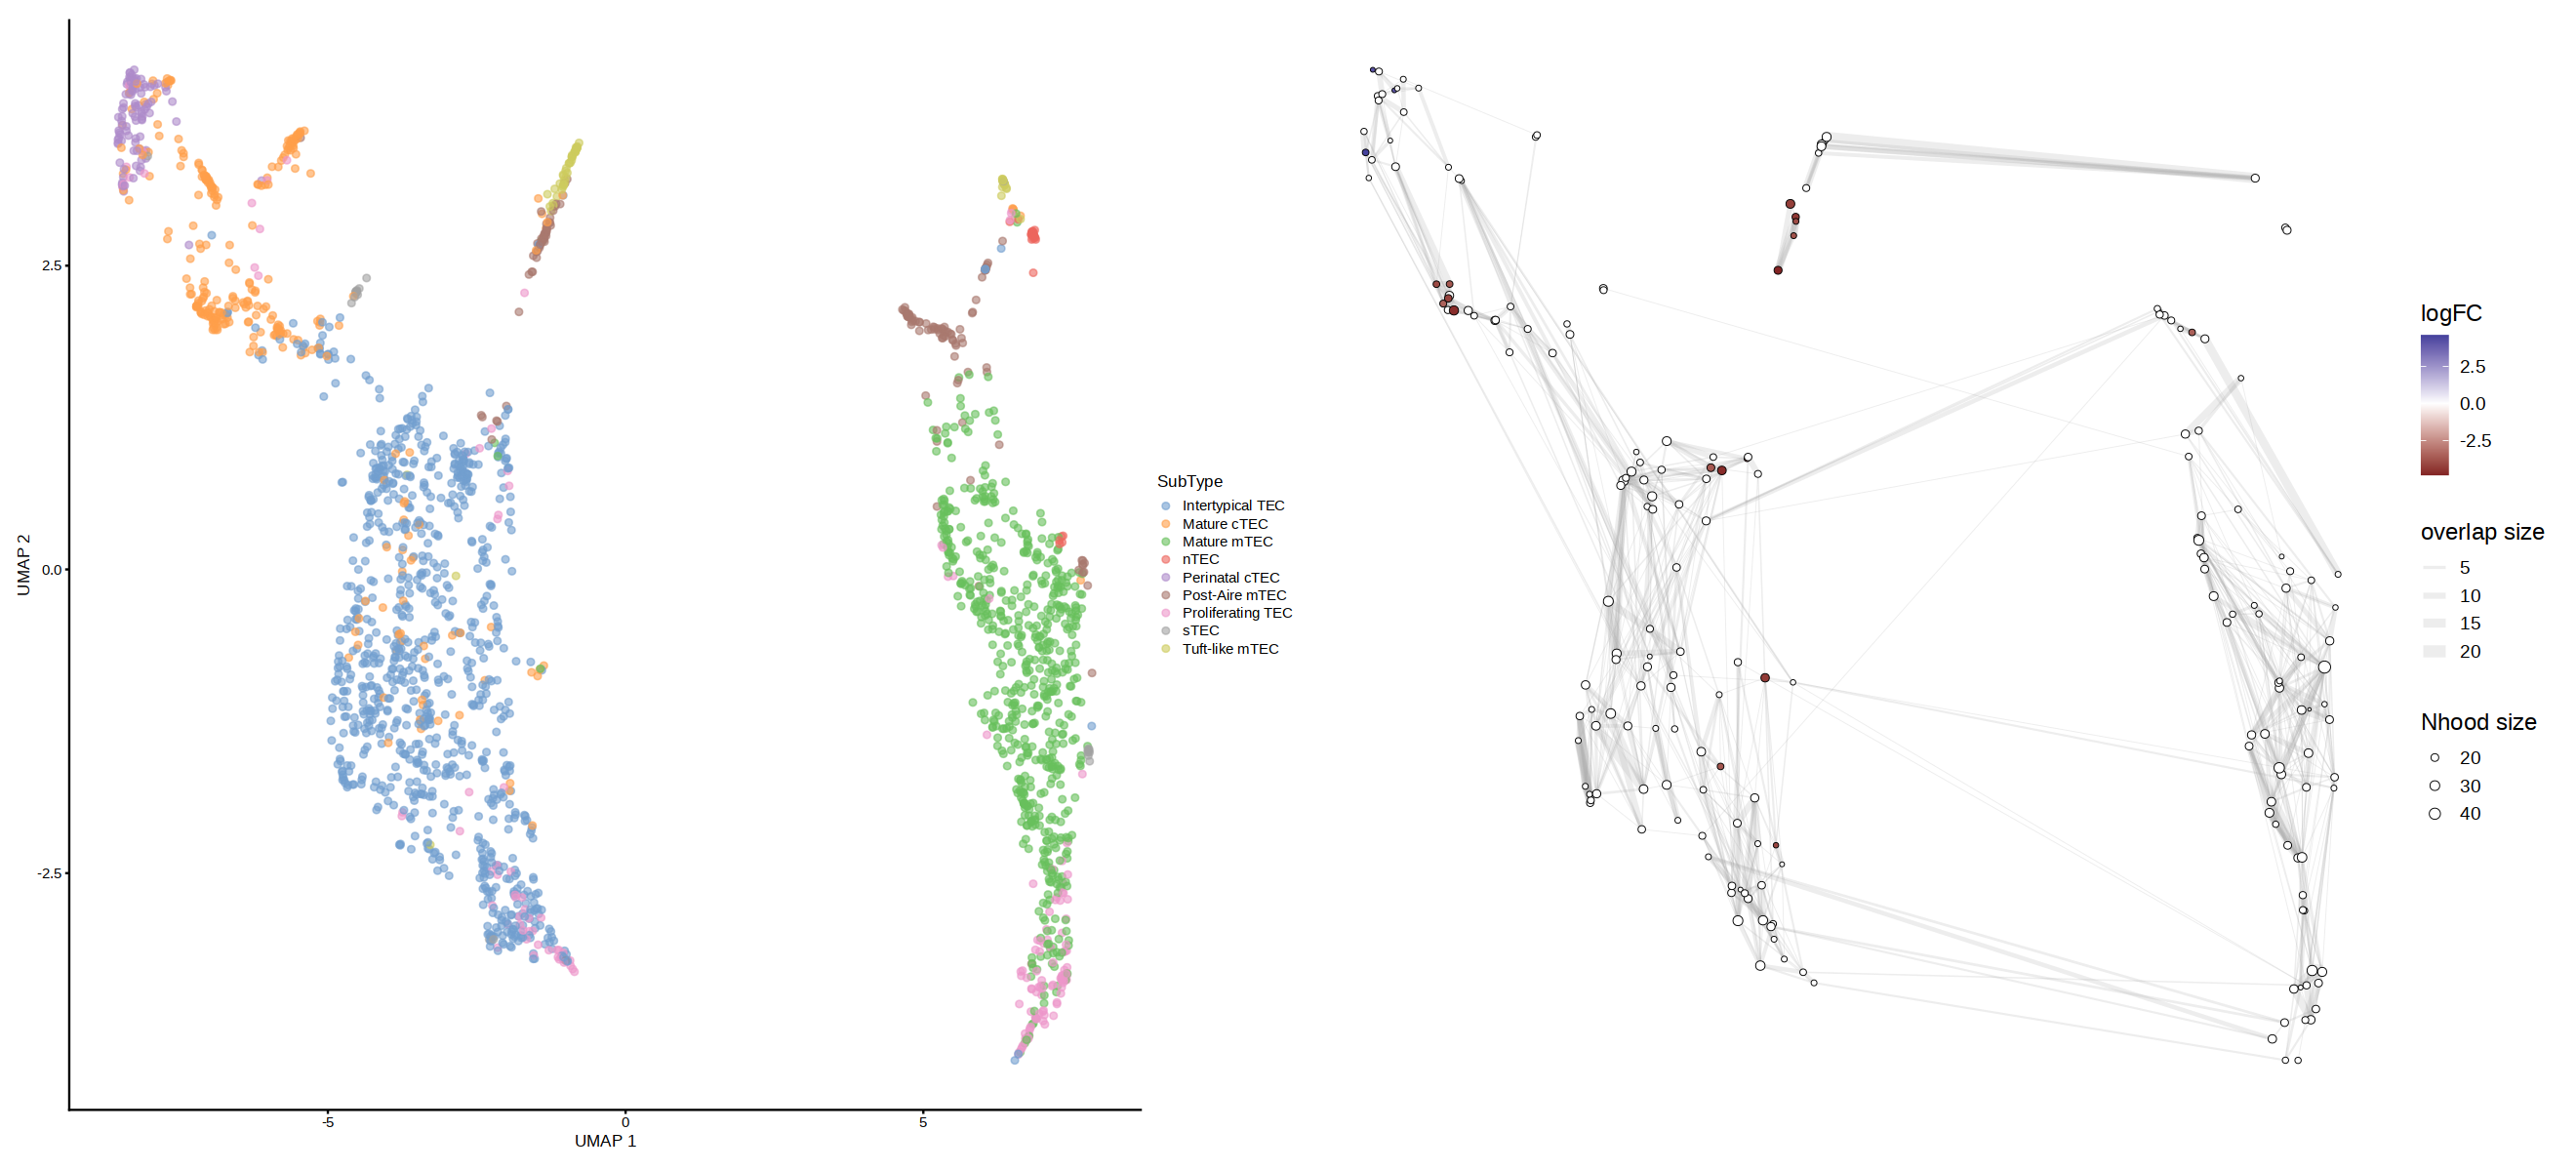

In [96]:
options(repr.plot.width=22, repr.plot.height=10)
thy.milo <- buildNhoodGraph(thy.milo)

plotUMAP(thy.milo, colour_by="SubType") + plotNhoodGraphDA(thy.milo, da_results, alpha=0.1) +
  plot_layout(guides="auto" )

In [97]:
factor(thy.design$Age) %>% levels %>% dput

c("1wk", "16wk", "32wk", "4wk", "52wk")


In [103]:
thy.design = thy.design %>%
mutate(Age = factor(Age, levels=c("16wk", "32wk", "4wk", "52wk", "1wk")))
thy.design

,Sample,SortDay,Age
,<chr>,<int>,<fct>
1_1wk,1_1wk,1,1wk
1_4wk,1_4wk,1,4wk
1_16wk,1_16wk,1,16wk
1_32wk,1_32wk,1,32wk
1_52wk,1_52wk,1,52wk
2_32wk,2_32wk,2,32wk
2_4wk,2_4wk,2,4wk
2_1wk,2_1wk,2,1wk
2_16wk,2_16wk,2,16wk


In [104]:
make_model_matrix = function(design_df){
    model <- model.matrix(~ 0 + Age, data=design_df)
    model
}

In [105]:
model_matrix = make_model_matrix(thy.design)

In [106]:
da_results <- testNhoods(thy.milo, design = model_matrix, design.df = thy.design, model.contrasts = ave.contrast, fdr.weighting="graph-overlap")

Using TMM normalisation

Performing spatial FDR correction withgraph-overlap weighting



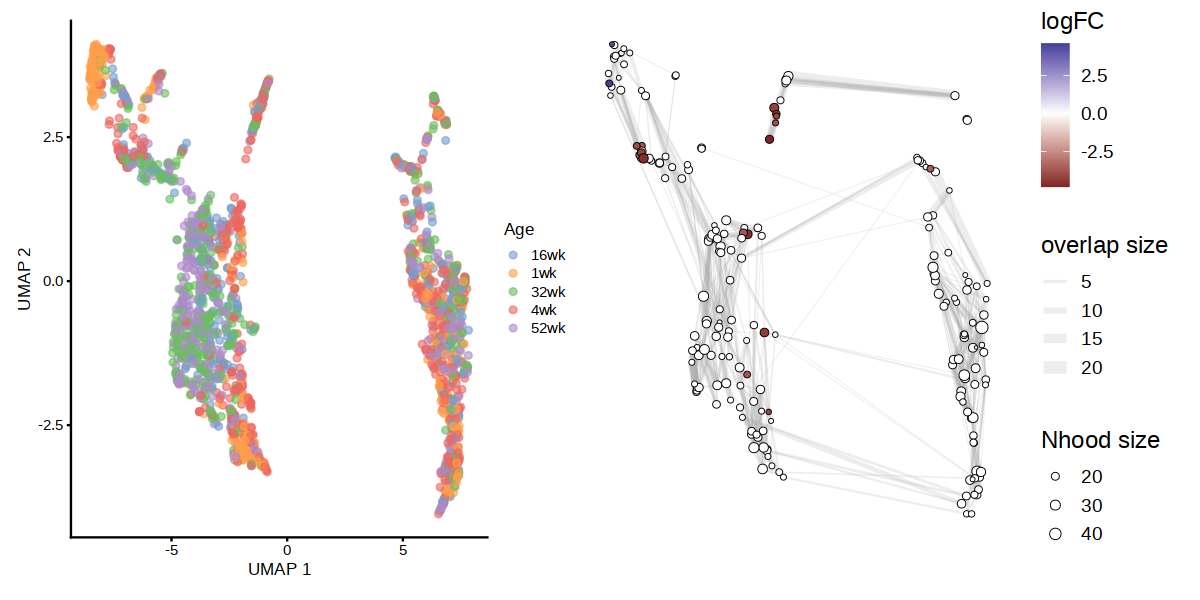

In [107]:
options(repr.plot.width=10, repr.plot.height=5)
thy.milo <- buildNhoodGraph(thy.milo)

plotUMAP(thy.milo, colour_by="Age") + plotNhoodGraphDA(thy.milo, da_results, alpha=0.1) +
  plot_layout(guides="auto" )